In [1]:
from analysis_utils import top_activations, influence, cosine_similarity_search
from plot_utils import examples_plot_df, examples_plot_df_horizontal, examples_plot_anthropic, plot_UMAP
from autoencoder import SparseAutoencoder

2025-01-21 11:46:17.367534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737456377.454618 3165562 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737456377.480906 3165562 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 11:46:17.698318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import glob
import torch
import numpy as np

In [3]:
import os
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from dotenv import load_dotenv

In [4]:
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [5]:

examples_dict = top_activations(
    feat_idx=53475,
    k=20,
    context_len=15,
    latent_dataset_path="../sparse_latent_vectors/latent_vectors_batch_*.pt",
    dataset_slice=(0,10),
    act_id_dataset="../activations_data/last3_batch_*.npy",
    tokenizer=tokenizer,
    verbose=False
)
print(examples_dict)

indicies = [58517, 8306, 26908, 50988, 53475]
top_examples = {}
for idx in indicies:
    top_examples[idx] = top_activations(idx, 20, 15, "../sparse_latent_vectors/latent_vectors_batch_*.pt", (0,10), "../activations_data/last3_batch_*.npy", tokenizer, verbose=False)

print("Top 1 example for feat 58517")
print(top_examples[58517][0])

/home/drew99/IJS/LLMinfluence/src/analysis_utils.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_vectors = torch.load(latent_file)
/home/drew99/IJS/LLMinfluence/

{0: {'file': '../sparse_latent_vectors/latent_vectors_batch_0_minibatch_14.pt', 'target_token': ',', 'target_token_value': 3.3009960651397705, 'context': ' savings  engineers  have  realized  from  their  use  of  engineering  software .ĊĊ In  Cam ber ly ,  U .K .,  the  design  team  at  res eller  Williams  Medical  Supplies  set  up  a', 'token_list': [' savings', ' engineers', ' have', ' realized', ' from', ' their', ' use', ' of', ' engineering', ' software', '.ĊĊ', 'In', ' Cam', 'ber', 'ly', ',', ' U', '.K', '.,', ' the', ' design', ' team', ' at', ' res', 'eller', ' Williams', ' Medical', ' Supplies', ' set', ' up', ' a'], 'activations': [0.0, 0.15066812932491302, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1570783108472824, 0.0, 0.4548317492008209, 0.5578505992889404, 0.4402541220188141, 3.3009960651397705, 1.3958834409713745, 0.0, 0.7055963277816772, 1.1470924615859985, 0.20066237449645996, 0.07120715081691742, 0.2556869089603424, 0.0, 0.0, 0.6075933575630188, 0.0034999018535017

In [6]:
examples_plot_df(top_examples[58517][0]) # Plots the top example for feature 58517

,Token,Activation
0,Jul,0.830769
1,ia,1.185810
2,K,3.466011
3,ogan,7.070708
4,ĊĊ,0.399795
5,Jul,1.502782
6,ia,0.998206
7,K,4.858819
8,ogan,3.474326
9,is,0.467571


In [22]:
examples_plot_df_horizontal(top_examples[58517][0])

/tmp/ipykernel_3143833/353120648.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


,Jul_0,ia_1,K_2,ogan_3,ĊĊ_4,Jul_5,ia_6,K_7,ogan_8,is_9,an_10,American_11,-F_12,rench_13,oper_14,atic_15,color_16,atura_17,sopr_18
Activation,0.830769,1.185810,3.466011,7.070708,0.399795,1.502782,0.998206,4.858819,3.474326,0.467571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256538


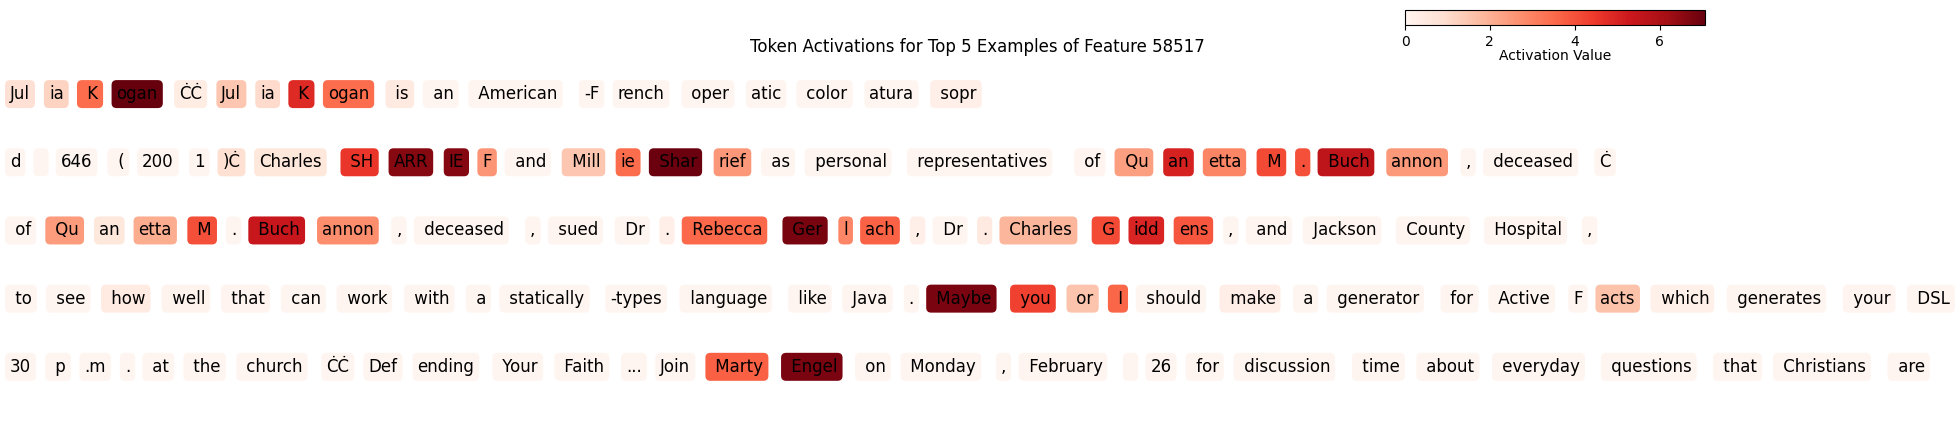

In [30]:
feat_idx = 58517
top5_examples = {}
top5_examples[feat_idx] = {}
for i in range(5):
    top5_examples[feat_idx][i] = top_examples[feat_idx][i]

examples_plot_anthropic(feat_idx, top5_examples[feat_idx], save_path=None)

In [31]:
# Load environment variables
load_dotenv("../.env")
hf_token = os.getenv("HF_TOKEN")

# Model and tokenizer setup
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_token)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)

# Load the sparse autoencoder model and weights
input_dim = 3072  
hidden_dim = 2 ** 16 # 65536
model_sae = SparseAutoencoder(input_dim, hidden_dim)
# model_sae.load_state_dict(torch.load("sparse_autoencoder.pth"))
checkpoint = torch.load("../models/checkpoint")
model_sae.load_state_dict(checkpoint['state_dict'])
# model_sae.eval()


/home/drew99/IJS/LLMinfluence/venvllm/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:796: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You shouldn't move a model that is dispatched using accelerate hooks.
/tmp/ipykernel_3143833/870694574.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torc

<All keys matched successfully>

In [33]:
gen_txt = influence(45783, 25.0, "I am a", 50, tokenizer, model, model_sae, verbose=True)

25.0 boost on feature 45783
Generated text with influence: 'I am a 20 year old female who has been diagnosed with a rare disease called Ehlers-Danlon syndrome. I have had 3 surgeries and 2 surgeries are still in progress. I have had 2 surgeries in the past 2 years. I'


In [4]:

latent_vector_files = sorted(glob.glob("../sparse_latent_vectors/latent_vectors_batch_*.pt"))
top_k_features = cosine_similarity_search(12219, 25, latent_vector_files, verbose=True)


/home/drew99/IJS/LLMinfluence/src/analysis_utils.py:320: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_vectors = torch.load(latent_file)[:,:-3]  # Load current chunk


Feature 12219 has aggregated similarity 95.0000
Feature 33348 has aggregated similarity 24.2779
Feature 56081 has aggregated similarity 21.4517
Feature 48378 has aggregated similarity 21.2307
Feature 49406 has aggregated similarity 20.9326
Feature 60636 has aggregated similarity 20.8537
Feature 50974 has aggregated similarity 20.7454
Feature 17505 has aggregated similarity 20.6152
Feature 1594 has aggregated similarity 20.4244
Feature 57862 has aggregated similarity 20.2067
Feature 7914 has aggregated similarity 20.1541
Feature 40773 has aggregated similarity 20.1271
Feature 60113 has aggregated similarity 20.1265
Feature 36097 has aggregated similarity 20.1095
Feature 61739 has aggregated similarity 20.0652
Feature 40515 has aggregated similarity 19.9952
Feature 23242 has aggregated similarity 19.8270
Feature 19980 has aggregated similarity 19.8028
Feature 102 has aggregated similarity 19.7638
Feature 44440 has aggregated similarity 19.7061
Feature 31970 has aggregated similarity 19.3

/home/drew99/IJS/LLMinfluence/src/plot_utils.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_vectors = torch.load(batch_file).cpu().numpy()


Loaded 95 batches, total shape: (389120, 97)


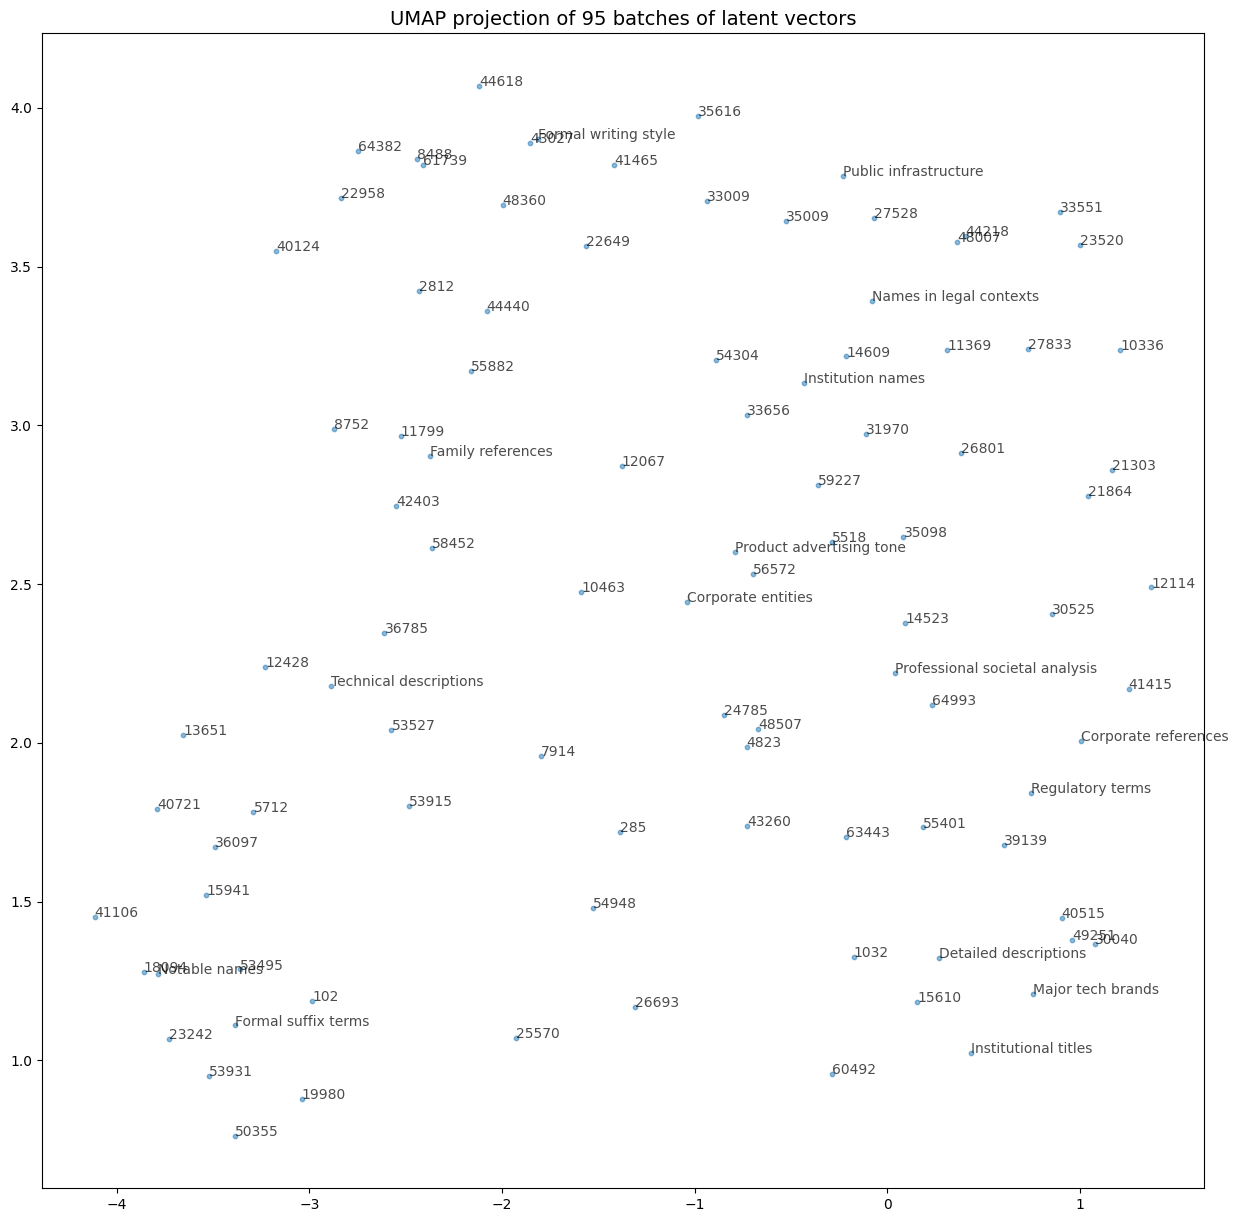

In [6]:

ixs = [12219, 33348, 56081, 48378, 49406, 60636, 50974, 17505, 1594, 57862, 7914, 40773, 60113,
 36097, 61739, 40515, 23242, 19980, 102, 44440, 31970, 53915, 50355, 42403, 41106, 2812, 36770, 35616,
 27833, 35098, 48360, 11369, 35009, 40721, 33551, 10336, 27528, 18094, 64382, 14609, 59227, 33009,
 22958, 21864, 26801, 60492, 33656, 48507, 12114, 8488, 1032, 25570, 5518, 41465, 58452, 11799,
 53527, 26536, 48007, 22649, 12428, 43027, 49251, 44218, 8752, 30040, 63443, 285, 39139, 36785,
 15941, 23520, 14523, 21303, 45157, 55401, 30525, 53495, 53931, 4823, 55882, 64993, 43260,
 15610, 54948, 40124, 56572, 26693, 44618, 12067, 41415, 24785, 5712, 23393, 54304, 10463,
 13651, 31034, 32965, 55900]
feature_names = {
    50974: 'Detailed descriptions',
    23393: 'Public infrastructure',
    33348: 'Institution names',
    12219: 'Corporate entities',
    36770: 'Professional societal analysis',
    26536: 'Product advertising tone',
    45157: 'Institutional titles',
    56081: 'Major tech brands',
    48378: 'Notable names',
    49406: 'Technical descriptions',
    60636: 'Family references',
    17505: 'Formal writing style',
    1594: 'Names in legal contexts',
    57862: 'Regulatory terms',
    40773: 'Formal suffix terms',
    60113: 'Corporate references'
}
plot_UMAP(ixs, feature_names, latent_vector_files, save_path=None)